In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal,Uniform
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot
from pymc3 import summary
import theano.tensor as tt
import theano as T
import math

df = pd.read_csv("../data/data-changepoint.txt")
T = df.values[:100,0].astype(np.float32)
Y = df.values[:100,1].astype(np.float32)
n_times = 100
#n_times = len(df["X"].unique()) #時間の数
basic_model = Model()

#subtensorの使い方↓
#http://deeplearning.net/software/theano/library/tensor/basic.html

with basic_model: 
    #事前分布
    #コーシー分布は逆関数法にて乱数生成
    s_mu =  HalfNormal('s_mu', sd=1) #コーシー分布の分散
    s_Y =  HalfNormal('s_Y', sd=1) #観測誤差
    mu_0 = Normal('mu_0',mu=0, sd=1)  #初期状態
    x = Uniform("x" ,lower=-math.pi/2,upper=math.pi/2, shape=n_times-1)
    
    #Cauchyの誤差process
    c = tt.dot(s_mu,tt.tan(x))
    
    #状態process
    mu = tt.zeros((n_times))
    mu = tt.set_subtensor(mu[0], mu_0)
    for i in list(range(n_times-1)):
        mu = tt.set_subtensor(mu[i+1], mu[i]+c[i])

    #likelihood
    Y_obs = Normal('Y_obs', mu=mu, sd=s_Y, observed=Y)    
    
    #サンプリング 
    trace = sample(1000,n_init=5000)
    summary(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,281.3: 100%|██████████| 5000/5000 [00:05<00:00, 836.81it/s]
Finished [100%]: Average ELBO = -737.32
100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s]


mu_0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.099            0.190            0.006            [-0.318, 0.495]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.318         0.000          0.107          0.204          0.495


s_mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.008            0.010            0.001            [0.000, 0.028]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.002          0.004          0.011          0.037


s_Y:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12662ca20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126bbc908>]], dtype=object)

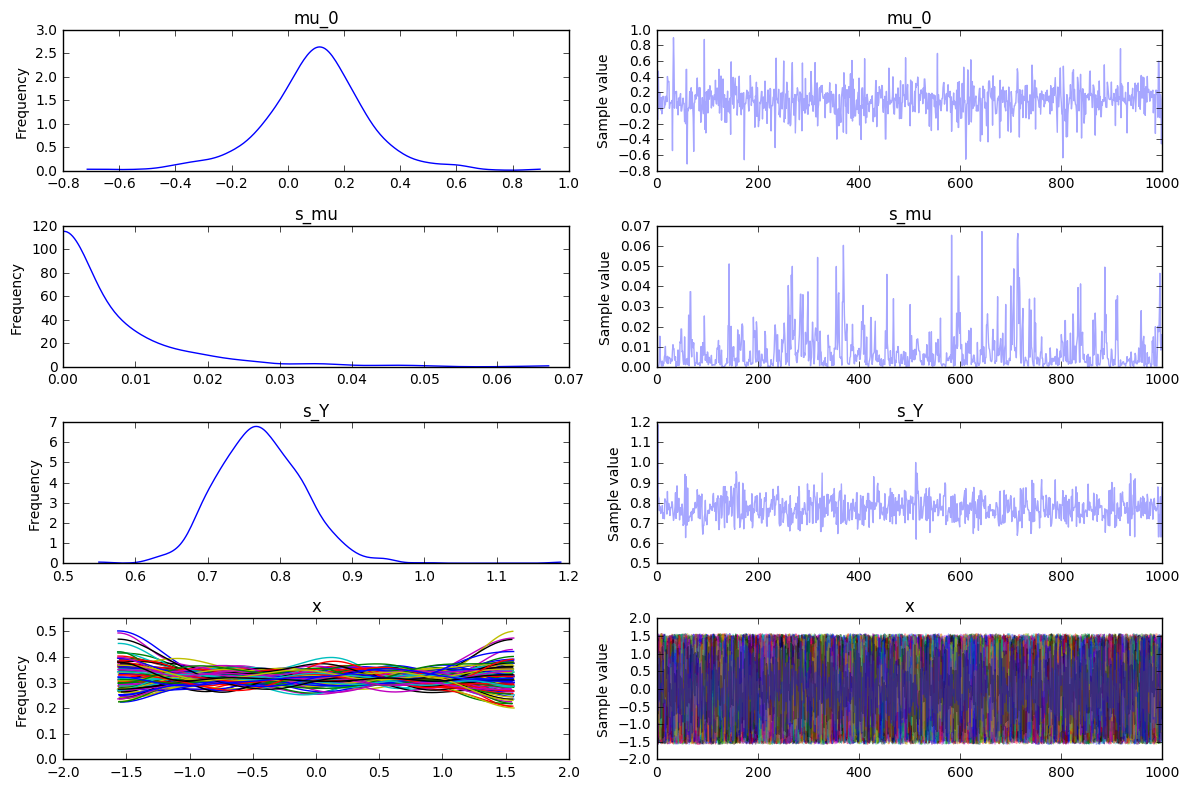

In [4]:
%matplotlib inline    
traceplot(trace)

In [25]:
s_mu =  np.diag(trace["s_mu",500:])
x = trace["x",500:]
print(s_mu.shape,x.shape)
c = np.dot(s_mu,np.tan(x))
c.shape

mu_zero = trace["mu_0",500:]
Y_obs = np.zeros((500,100))
Y_obs[:,0] = mu_zero 
for i in range(99):
    Y_obs[:,i+1] = c[:,i] + Y_obs[:,i]


(500, 500) (500, 99)


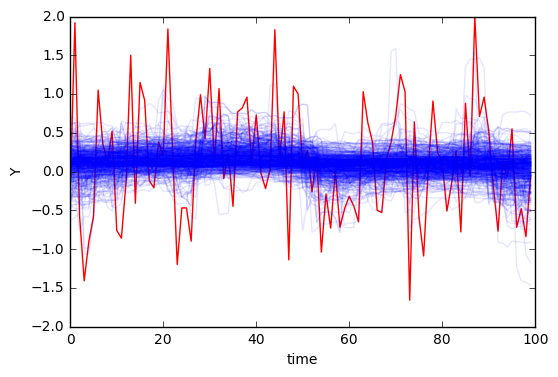

In [26]:
%matplotlib inline
plt.plot(df.values[:100,1],"r")
plt.plot(Y_obs.T , 'b', alpha=.1)
plt.xlabel('time')
plt.ylabel('Y')